In [4]:
import torch
from torch import nn
from d2l import torch as d2l

def batch_norm(X, gamma, beta, moving_mean, moving_var, eps, momentum):
    if not torch.is_grad_enabled():
        X_hat = (X - moving_mean) / torch.sqrt(moving_var + eps)
    else:
        assert len(X.shape) in (2, 4)
        if len(X.shape) == 2:
            mean = X.mean(dim=0)
            var = ((X - mean)**2).mean(dim=0)
        else:
            mean = X.mean(dim=(0, 2, 3), keepdim=True)
            var = ((X - mean)**2).mean(dim=(0, 2, 3), keepdim=True)
        X_hat = (X - mean) / torch.sqrt(var + eps)
        moving_mean = momentum * moving_mean + (1.0 - momentum) * mean
        moving_var = momentum * moving_var + (1.0 - momentum) * var
    Y = gamma * X_hat + beta
    return Y, moving_mean.data, moving_var.data

In [5]:
class BatchNorm(nn.Module):
    def __init__(self, num_features, num_dims):
        super().__init__()
        if num_dims == 2:
            shape = (1, num_features)
        else:
            shape = (1, num_features, 1, 1)
        self.gamma = nn.Parameter(torch.ones(shape))
        self.beta = nn.Parameter(torch.zeros(shape))
        self.moving_mean = torch.zeros(shape)
        self.moving_var = torch.zeros(shape)

    def forward(self, X):
        if self.moving_mean.device != X.device:
            self.moving_mean = self.moving_mean.to(X.device)
            self.moving_var = self.moving_var.to(X.device)
        Y, self.moving_mean, self.moving_var = batch_norm(
            X, self.gamma, self.beta, self.moving_mean, self.moving_var,
            eps=1e-5, momentum=0.9)
        return Y

In [7]:
net = nn.Sequential(
    nn.Conv2d(1, 6, kernel_size=5), BatchNorm(6, num_dims=4),
    nn.Sigmoid(), nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Conv2d(6, 16, kernel_size=5), BatchNorm(16, num_dims=4),
    nn.Sigmoid(), nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Flatten(), nn.Linear(16 * 4 * 4, 120),
    BatchNorm(120, num_dims=2), nn.Sigmoid(),
    nn.Linear(120, 84), BatchNorm(84, num_dims=2),
    nn.Sigmoid(), nn.Linear(84, 10)
)

loss 0.239, train acc 0.912, test acc 0.866
23600.2 examples/sec on cuda:0


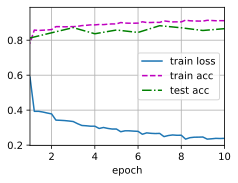

In [9]:
import torchvision
from torch.utils import data
from torchvision import transforms

def get_dataloader_workers():
    """使用四个进程来读取数据。"""
    return 4

def load_data_fashion_mnist(batch_size, resize=None):
    """下载Fashion-MNIST数据集，然后将其加载到内存中。"""
    trans = [transforms.ToTensor()]
    if resize:
        trans.insert(0, transforms.Resize(resize))
    trans = transforms.Compose(trans)
    mnist_train = torchvision.datasets.FashionMNIST(
        root='./data', train=True, transform=trans, download=True)
    mnist_test = torchvision.datasets.FashionMNIST(
        root='./data', train=False, transform=trans, download=True)
    return (data.DataLoader(mnist_train, batch_size, shuffle=True,
                            num_workers=get_dataloader_workers()),
            data.DataLoader(mnist_test, batch_size, shuffle=False,
                            num_workers=get_dataloader_workers()))

lr, num_epochs, batch_size = 1.0, 10, 256
train_iter, test_iter = load_data_fashion_mnist(batch_size)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

In [13]:
net[1].gamma.reshape(-1,), net[1].beta.reshape(-1,)

(tensor([1.9654, 2.2283, 1.1977, 1.4582, 1.9259, 4.3955], device='cuda:0',
        grad_fn=<ReshapeAliasBackward0>),
 tensor([-0.5355,  0.2551, -0.7871, -1.2807, -1.0402,  3.8816], device='cuda:0',
        grad_fn=<ReshapeAliasBackward0>))

In [15]:
net = nn.Sequential(
    nn.Conv2d(1, 6, kernel_size=5), nn.BatchNorm2d(6),
    nn.Sigmoid(), nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Conv2d(6, 16, kernel_size=5), nn.BatchNorm2d(16),
    nn.Sigmoid(), nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Flatten(), nn.Linear(256, 120),
    nn.BatchNorm1d(120),
    nn.Sigmoid(), nn.Linear(120, 84),
    nn.BatchNorm1d(84),
    nn.Sigmoid(), nn.Linear(84, 10)
)

loss 0.236, train acc 0.913, test acc 0.879
42835.0 examples/sec on cuda:0


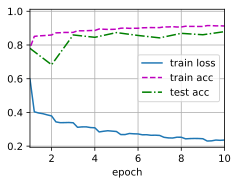

In [17]:
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())